# Home2
Your home away from home <br>
The best location for your needs, anywhere in the world <br>
### Inputs: 
    places (eg. 'Bend, Oregon')
    Category List (eg. 'food', 'restaurant', 'gym', 'trails', 'school', 'train station')
### Outputs:
    Map of venues
    place near centroid
    Hotels near centroid

## User Input

In [1]:
# places to analyze venues around and obtain best location
places=['Bend, Oregon'] 
# 4square Venue categories of interest (https://docs.foursquare.com/data-products/docs/categories#find-a-category-id)
categories=['Museum','Thai restaurant','Gym','night market','national park','state park','trail','airport']  

## Import Libraries

In [42]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import math

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an place into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

#!conda install -c conda-forge folium=0.5.0 --yes # 
import folium # map rendering library
 

print('Libraries imported.')

Libraries imported.


In [3]:
# Limit of search results  
LIMIT=50
centroid_mean_median='mean'
# Radius of search in km (maximum 100)
radius=20
# Radius in km to search hotels around from final optimum location (centroid). This list is also sorted by likes    
hotel_radius=20 
radius,hotel_radius=radius*1000,hotel_radius*1000

## Functions and Classes

In [4]:
def build_tree(data, parent=None):
    from anytree import Node, RenderTree
    # Define the root node inside the function
    root = Node("root")
    def _build_tree(data, parent):
        if isinstance(data, dict):
            for key, value in data.items():
                node = Node(key, parent=parent)
                _build_tree(value, node)
        elif isinstance(data, list):
            for index, item in enumerate(data):
                node = Node(f'Item {index}', parent=parent)
                _build_tree(item, node)
        else:
            Node(data, parent=parent)
    # Build the tree from the JSON data
    _build_tree(data, root)
    # Print the tree
    for pre, fill, node in RenderTree(root):
        print(f"{pre}{node.name}")
        
def extract_name_id_pairs(dictionary):
    var = {}
    def explore_dict(d):
        if isinstance(d, dict):
            if 'name' in d and 'id' in d:
                var[d['name'].lower()] = d['id']
            for key, value in d.items():
                explore_dict(value)
        elif isinstance(d, list):
            for item in d:
                explore_dict(item)
    explore_dict(dictionary)
    return var


Function to get centroids from a df of places

In [5]:
def centroids(place_df):
    ''' Returns the centroid of a df of places as a dictionary of place:(lat,long)'''
    if centroid_mean_median=='mean':
        centroid_dict={place:(place_df[place_df.Address==place]['Venue Latitude'].mean(),place_df[
            place_df.Address==place]['Venue Longitude'].mean()) for place in places}
    else:
        centroid_dict={place:(place_df[place_df.Address==place]['Venue Latitude'].median(),place_df[
            place_df.Address==place]['Venue Longitude'].median()) for place in places}
    return centroid_dict

Define function to calculate distance based on geo-coordinates

In [29]:
def geodistance (coord1,coord2):
    R = 6373.0                          ## Radius of Earth in kms.
    lat1,long1=coord1                   # Latitude and Longitude of coord1
    lat2,long2=coord2                   # Latitude and Longitude of coord2
    latd1 = math.radians(coord1[0])     # Latitude of coord1 calculated in radians
    lon1 = math.radians(coord1[1])     # Longitude of coord1 calculated in radians
    latd2 = math.radians(coord2[0])     # Latitude of coord2 calculated in radians
    lon2 = math.radians(coord2[1])     # Longitude of coord2 calculated in radians

    dlon = lon2 - lon1
    dlat = latd2 - latd1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c * 1000                    # Geo-distance in m.
    return distance

Function to get nearby venues matching the "categories" given place

In [7]:
def getNearbyVenues(names, latitudes, longitudes,url_link,categories, radius):
    ''' Create the venue search url and lookup nearby venues and return as dataframe'''
    venues_list=[]
    for i in range(len(names)):
        name=names[i]
        lat=latitudes[i]
        lng = longitudes[i]
        for category in categories:    
            # create the API request URL
            url = url_link.format(
                category,
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng, 
                VERSION,
                radius,
                LIMIT)
            # make the GET request
            results = requests.get(url).json()    
            
            try:
                # return only relevant information for each nearby venue
                for j in range(len(results['response']['venues'])):
                        venues_list.append([
                        name, 
                        results['response']['venues'][j]['name'],
                        results['response']['venues'][j]['id'],
                        results['response']['venues'][j]['location']['lat'], 
                        results['response']['venues'][j]['location']['lng'],  
                        results['response']['venues'][j]['categories'][0]['name'],
                        category, 
                        results['response']['venues'][j]['location']['distance'],
                        ])
            except Exception as E:
                    print(E)
        
    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Address',
              'Venue', 
              'Venue_id',
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category',
              'Category ID',
              'Distance [m]']

    # Convert distance to geodistance from centroid
    nearby_venues['Distance [m]']=nearby_venues.apply(lambda x:geodistance((x['Venue Latitude'],x['Venue Longitude']),(lat,lng)),axis=1).astype(int)
    
    return(nearby_venues)

def getVenueLikes(venue_ids):
    ''' Obtain the list of number of likes for the venues in "venue_ids"'''
    likes_list=[]
    for i in range(len(venue_ids)): 
        # create the API request URL
        url_link='https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'
        url = url_link.format(venue_ids[i],
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION)

        # make the GET request
        results = requests.get(url).json()
        
        likes_list.append(results['response']['venue']['likes']['count'])

       
    return(likes_list)

## Obtain Location and Venue information in a Dataframe

### Create Geolocator using Nominatim and Obtain Location info. for the places

In [8]:
geoagent="explorer"

lat=[]
long=[]
for place in places:
    geolocator = Nominatim(user_agent=geoagent)
    loc = geolocator.geocode(place)
    lat.append(loc.latitude)
    long.append(loc.longitude)
    print('The geograpical coordinates of '+place +' are {}, {}.'.format(lat[-1], long[-1]))



The geograpical coordinates of Bend, Oregon are 44.0581728, -121.3153096.


In [9]:
df_loc=pd.DataFrame({'Place': places,'Latitude': lat, 'Longitude':long})
df_loc

,Place,Latitude,Longitude
0,"Bend, Oregon",44.058173,-121.31531


### Foursquare Credentials

In [32]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### Make list of category names by ID

In [11]:
categories_url='https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID,
                                                                                                            CLIENT_SECRET,
                                                                                                            VERSION)
result=requests.get(categories_url).json()
# build_tree(result)
# Build the tree from the JSON data
cat_info=result['response']['categories']
category_dict=extract_name_id_pairs(cat_info)
categories=[category_dict[cat.lower()] for cat in categories if cat.lower() in list(category_dict.keys()) ]
cat_dict = {value: key for key, value in category_dict.items()}

In [12]:
# General Search URL string
url_str='https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'
# Zipcode Search URL string
url_str_zip='https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'

### Explore nearby venues

Dataframe of Venues for each place, matching the "categories"

In [13]:
# Implement 'getNearbyVenues'
loc_venues_place=getNearbyVenues(df_loc['Place'], df_loc['Latitude'],df_loc['Longitude'],url_str,categories,radius)
loc_venues_place.head()

,Address,Venue,Venue_id,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m]
0,"Bend, Oregon",Deschutes Historical Museum,4ccb7562063a721eb3ff879a,44.055381,-121.316909,History Museum,4bf58dd8d48988d181941735,357
1,"Bend, Oregon",Petersen Rock Museum,4c3b80115810a593a9c4ba3c,44.203122,-121.262437,Public Art,4bf58dd8d48988d181941735,17134
2,"Bend, Oregon",Sunriver Observatory,4f125b2fe4b0a6ade14b6faf,43.885204,-121.447711,Science Museum,4bf58dd8d48988d181941735,24194
3,"Bend, Oregon",High Desert Museum,4b63435ff964a520656e2ae3,43.966331,-121.343029,Museum,4bf58dd8d48988d181941735,10669
4,"Bend, Oregon",Noi,505bb453e4b0236a2689ff75,44.057642,-121.313628,Thai Restaurant,4bf58dd8d48988d149941735,195


## Exploratory Data Analysis (EDA)

In [38]:
# Implement 'getNearbyVenues'
print(loc_venues_place.info())
print(loc_venues_place.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Deschutes Historical Museum to Bend Municipal Airport (BDN)
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Address          58 non-null     object 
 1   Venue_id         58 non-null     object 
 2   Venue Latitude   58 non-null     float64
 3   Venue Longitude  58 non-null     float64
 4   Venue Category   58 non-null     object 
 5   Category ID      58 non-null     object 
 6   Distance [m]     58 non-null     int32  
dtypes: float64(2), int32(1), object(4)
memory usage: 5.5+ KB
None
       Venue Latitude  Venue Longitude  Distance [m]
count       58.000000        58.000000     58.000000
mean        44.059446      -121.309162   4950.431034
std          0.057295         0.039483   5936.654632
min         43.885204      -121.447711    194.000000
25%         44.044308      -121.331853   1485.750000
50%         44.057086      -121.313239   3008.000000

Drop NaN values, set 'Venue' as index column since we are dealing with venues.

In [15]:
loc_venues_place.set_index('Venue',inplace=True)
loc_venues_place.dropna(inplace=True)
loc_venues_place.shape

(58, 7)

Print number of categories for each place

In [16]:
for i in range(len(places)):
    print('There are {} uniques categories (including subcategories) for '
          .format(len(loc_venues_place.loc[loc_venues_place['Address']==places[i],'Venue Category'].unique()))+places[i])

There are 18 uniques categories (including subcategories) for Bend, Oregon


## Calculate Centroid and re-calculate the venues around the Centroid

In [17]:
# Calculate centroid of the venues for each place in loc_venues
loc_venues_centroids=centroids(loc_venues_place)
print(loc_venues_centroids)

{'Bend, Oregon': (44.05944647096349, -121.3091619674332)}


In [18]:
df_loc_centroid=pd.DataFrame({'Place': places,'Latitude': [coords[0] for coords in loc_venues_centroids.values()], 
'Longitude':[coords[1] for coords in loc_venues_centroids.values()]})
df_loc_centroid

,Place,Latitude,Longitude
0,"Bend, Oregon",44.059446,-121.309162


Dataframe of Venues for each place, matching the "categories"

In [19]:
# Implement 'getNearbyVenues'
loc_venues=getNearbyVenues(df_loc_centroid['Place'], df_loc_centroid['Latitude'],df_loc_centroid['Longitude'],url_str,categories,radius)
loc_venues.head()

,Address,Venue,Venue_id,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m]
0,"Bend, Oregon",Deschutes Historical Museum,4ccb7562063a721eb3ff879a,44.055381,-121.316909,History Museum,4bf58dd8d48988d181941735,970
1,"Bend, Oregon",Petersen Rock Museum,4c3b80115810a593a9c4ba3c,44.203122,-121.262437,Public Art,4bf58dd8d48988d181941735,16782
2,"Bend, Oregon",High Desert Museum,4b63435ff964a520656e2ae3,43.966331,-121.343029,Museum,4bf58dd8d48988d181941735,11019
3,"Bend, Oregon",Sunriver Observatory,4f125b2fe4b0a6ade14b6faf,43.885204,-121.447711,Science Museum,4bf58dd8d48988d181941735,24724
4,"Bend, Oregon",Wild Rose Northern Thai Eats,52a7831a498e5e0f1adc67c8,44.059512,-121.312962,Thai Restaurant,4bf58dd8d48988d149941735,421


## Exploratory Data Analysis

In [39]:
# Implement 'getNearbyVenues'
print(loc_venues.info())
print(loc_venues.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Deschutes Historical Museum to Leading Edge
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Address          58 non-null     object 
 1   Venue_id         58 non-null     object 
 2   Venue Latitude   58 non-null     float64
 3   Venue Longitude  58 non-null     float64
 4   Venue Category   58 non-null     object 
 5   Category ID      58 non-null     object 
 6   Distance [m]     58 non-null     int32  
 7   Cluster Labels   58 non-null     int64  
dtypes: float64(2), int32(1), int64(1), object(4)
memory usage: 5.9+ KB
None
       Venue Latitude  Venue Longitude  Distance [m]  Cluster Labels
count       58.000000        58.000000     58.000000       58.000000
mean        44.059446      -121.309162   4960.431034        1.793103
std          0.057295         0.039483   5887.702963        0.832637
min         43.885204      -121.447711     40.000000  

Drop NaN values, set 'Venue' as index column since we are dealing with venues.

In [21]:
loc_venues.set_index('Venue',inplace=True)
loc_venues.dropna(inplace=True)
loc_venues.shape

(58, 7)

Print number of categories for each place

In [37]:
for i in range(len(places)):
    print('There are {} unique venue categories (including subcategories)'
          .format(len(loc_venues_place.loc[loc_venues_place['Address']==places[i],'Venue Category'].unique())))

There are 18 unique venue categories (including subcategories)


### Make Folium plot to show venues

In [23]:
maps={}
loc_results_lat=[]
loc_results_long=[]
zip_results={}

i=0
for place in places:
    # create map
    clustered=loc_venues[loc_venues['Address']==place]
    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    venue_name=clustered.index
    
    # Calculate mean latitude and longitude
    latitude=lat_array.mean()                            
    longitude=long_array.mean()
    
    # Update results latitude and longitude arrays
    loc_results_lat.append(latitude)
    loc_results_long.append(longitude)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[place]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[place]='0'
    
    print('Centroid for '+str(place)+' at: '+str(round(latitude,5))+', '+str(round(longitude,5))
          +', Address:',zip_results[place][0])

    map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

    # add markers to the map
    markers_colors = []
    for lat, lon, name in zip(lat_array, long_array, 
                                 venue_name):
        label = folium.Popup(name, parse_html=True)
        folium.Marker(
            [lat, lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
                            ).add_to(map_clusters)
        
    folium.RegularPolygonMarker(location=[latitude, longitude], 
                                number_of_sides=5,
                                popup='Centroid', 
                                color='red', 
                                fill=True,
                                fill_color='yellow',
                                fill_opacity=0.8,
                                radius=20).add_to(map_clusters)
    
    maps[place]=map_clusters
    i=i+1

maps[places[0]]


Centroid for Bend, Oregon at: 44.05945, -121.30916, Address: 109 NE Greenwood  Suite # 104


### Make Venue Longitude and Latitude box plots

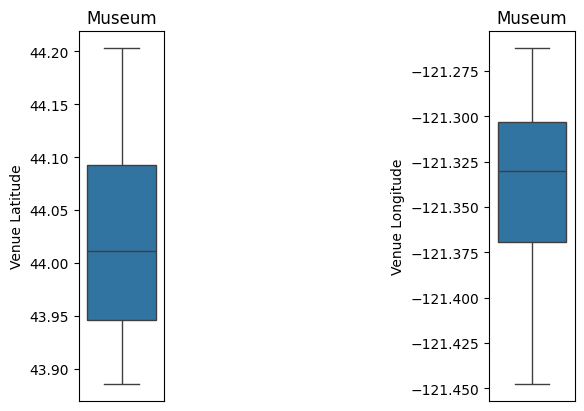

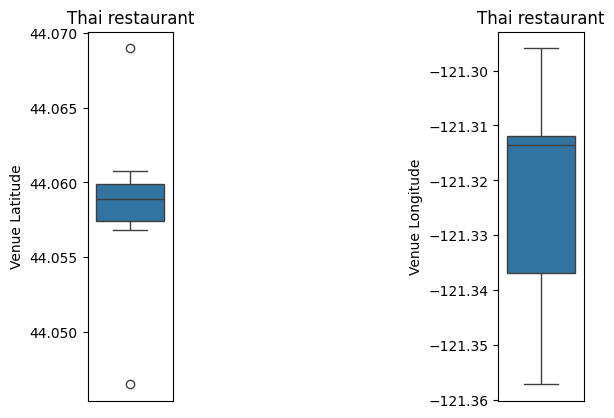

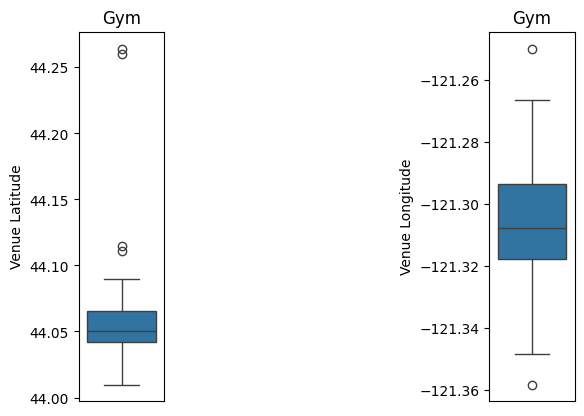

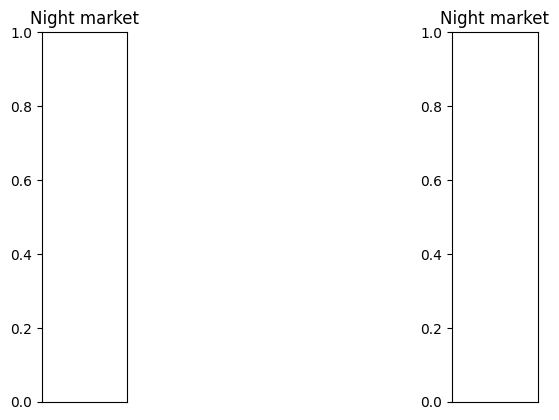

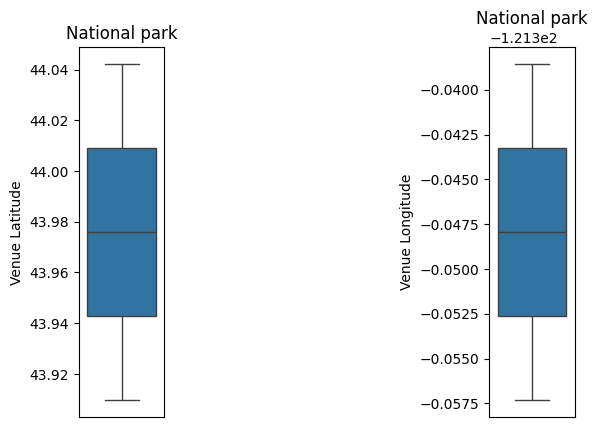

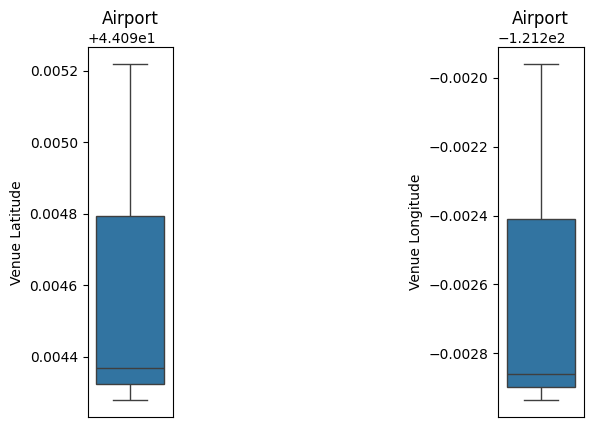

In [44]:
fnum=1

unique_cat=len(loc_venues['Category ID'].unique())+1
bp={}                                                   # Box plot object dict.

for i in range(0,unique_cat):
    plt.figure()
    plt.subplot(1,5,1)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Latitude']
    bp[categories[i]+'.Latitude']=(sns.boxplot(Y))
    plt.xlabel('Latitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]).capitalize())

    plt.subplot(1,5,5)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Longitude']
    bp[categories[i]+'.Longitude']=(sns.boxplot(Y))
    plt.xlabel('Longitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]).capitalize())

fnum=fnum+1

## Encoding Venue Categories

In [25]:
cat_num_dict={cat_id:i for i,cat_id in enumerate(loc_venues['Category ID'].unique())}
loc_venues['Cluster Labels']=loc_venues['Category ID'].apply(lambda x:cat_num_dict[x])
loc_venues.head()

,Address,Venue_id,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m],Cluster Labels
Venue,,,,,,,,
Deschutes Historical Museum,"Bend, Oregon",4ccb7562063a721eb3ff879a,44.055381,-121.316909,History Museum,4bf58dd8d48988d181941735,970,0
Petersen Rock Museum,"Bend, Oregon",4c3b80115810a593a9c4ba3c,44.203122,-121.262437,Public Art,4bf58dd8d48988d181941735,16782,0
High Desert Museum,"Bend, Oregon",4b63435ff964a520656e2ae3,43.966331,-121.343029,Museum,4bf58dd8d48988d181941735,11019,0
Sunriver Observatory,"Bend, Oregon",4f125b2fe4b0a6ade14b6faf,43.885204,-121.447711,Science Museum,4bf58dd8d48988d181941735,24724,0
Wild Rose Northern Thai Eats,"Bend, Oregon",52a7831a498e5e0f1adc67c8,44.059512,-121.312962,Thai Restaurant,4bf58dd8d48988d149941735,421,1


## Display Results

### Generate analyzed map array for each place using folium, and display location for each place

In [26]:
maps={}
loc_results_lat=[]
loc_results_long=[]
zip_results={}

kclusters=max(loc_venues['Cluster Labels'])+1

for i,place in enumerate(places):
    # create map
    clustered=loc_venues[loc_venues['Address']==place]
    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    
    # Calculate mean latitude and longitude
    latitude=loc_venues_centroids[place][0]                        
    longitude=loc_venues_centroids[place][1] 
    
    # Update results latitude and longitude arrays
    loc_results_lat.append(latitude)
    loc_results_long.append(longitude)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[place]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[place]='0'
    
    print('Centroid at: '+str(round(latitude,5))+', '+str(round(longitude,5))
          +', Address:',zip_results[place][0])

    map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [j + x + (j*x)**2 for j in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(j) for j in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster, category in zip(lat_array, long_array, 
                                      clustered.index, clustered['Cluster Labels'], clustered['Category ID']):
        label = folium.Popup(str(poi) + ' Type: ' + str(cat_dict[category]).capitalize(), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7,
                            ).add_to(map_clusters)
    
    folium.RegularPolygonMarker(location=[latitude, longitude], 
                                number_of_sides=5,
                                popup='Centroid', 
                                color='red', 
                                fill=True,
                                fill_color='yellow',
                                fill_opacity=0.8, 
                                radius=7).add_to(map_clusters)
    
    maps[place]=map_clusters
maps[place]

Centroid at: 44.05945, -121.30916, Address: 109 NE Greenwood  Suite # 104


### Get hotels near venues

In [27]:
hotel_category=['4bf58dd8d48988d1fa931735']                # Category for Hotels

# Enter Hotel Search URL string
url_str_hotels='https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'

df_hotels=df_loc.copy()

df_hotels['Latitude']=[value[0] for value in loc_venues_centroids.values()] 
df_hotels['Longitude']=[value[1] for value in loc_venues_centroids.values()]
# Get hotels list
hotels=getNearbyVenues(names=df_hotels['Place'], latitudes=df_hotels['Latitude'],longitudes=df_hotels['Longitude'],
                       url_link=url_str_hotels,categories=hotel_category,radius=hotel_radius)

hotel_ids=hotels['Venue_id'].tolist()
# Get Likes list for hotels
likes_list=getVenueLikes(hotel_ids)

hotels['Likes']=likes_list
hotels['Distance [km]']=(hotels['Distance [m]']/1000).astype(int)

hotels.drop(columns=['Category ID','Venue_id','Distance [m]'],inplace=True)
hotels.sort_values(by=['Likes','Distance [km]'],ascending=[False,True],inplace=True)
hotels.set_index('Venue',drop=True,inplace=True)

# Cluster hotels by likes from 1 to 4
likes_clusters=np.arange(1,5)
likes_bracket=np.linspace(0,max(likes_list),5)
hotels['Cluster Labels'] = hotels['Likes'].apply(lambda z: next((
    likes_clusters[i] for i in range(len(likes_clusters)) if likes_bracket[i] <= z < likes_bracket[i + 1]), 
    likes_clusters[-1] if z == likes_bracket[-1] else None))

hotels.drop(columns=['Cluster Labels'])

,Address,Venue Latitude,Venue Longitude,Venue Category,Likes,Distance [km]
Venue,,,,,,
Sunriver Resort,"Bend, Oregon",43.873991,-121.446471,Resort,83,25
Riverhouse on the Deschutes,"Bend, Oregon",44.079231,-121.305370,Hotel,37,2
The Oxford Hotel,"Bend, Oregon",44.057747,-121.312222,Hotel,19,0
Fairfield Inn & Suites Bend Downtown,"Bend, Oregon",44.066474,-121.308305,Hotel,18,0
WorldMark Bend - Seventh Mountain Resort,"Bend, Oregon",43.996047,-121.397476,Hotel,18,12
TownePlace Suites Bend,"Bend, Oregon",44.042342,-121.331271,Hotel,11,3
Hampton Inn by Hilton,"Bend, Oregon",44.044355,-121.318257,Hotel,10,1
Residence Inn By Marriott Bend,"Bend, Oregon",44.044976,-121.310235,Hotel,8,1
SpringHill Suites by Marriott Bend,"Bend, Oregon",44.049909,-121.315307,Hotel,7,1


### Plot map

In [28]:
hotel_maps={}
zip_results={}
kclusters=max(loc_venues['Cluster Labels'])+1

for i,place in enumerate(places):
    clustered=hotels[hotels.Address==place]

    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    
    # Calculate mean latitude and longitude
    latitude=loc_venues_centroids[place][0]                           
    longitude=loc_venues_centroids[place][1]
        
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[place]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[place]='0'
    
    print('Centroid at: ' +str(round(latitude,5))+', '+str(round(longitude,5))
          +',Centroid Address:',zip_results[place][0])

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [j + x + (j*x)**2 for j in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))
    rainbow = [colors.rgb2hex(j) for j in colors_array]

    # add markers to the map (Score based on Likes)
    markers_colors = []
    for lat, lon, poi, cluster in zip(lat_array, long_array, 
                                    clustered.index, clustered['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Score(' + str(cluster)+'/4): ', parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7,
                            ).add_to(map_clusters)
    folium.RegularPolygonMarker(location=[latitude, longitude], 
                            number_of_sides=5,
                            popup='Centroid', 
                            color='red', 
                            fill=True,
                            fill_color='yellow',
                            fill_opacity=0.8,
                            radius=7).add_to(map_clusters)
    
    hotel_maps[place]=map_clusters
hotel_maps[place]

Centroid at: 44.05945, -121.30916,Centroid Address: 109 NE Greenwood  Suite # 104
